# Multimodal Music Emotion Recognition (MIREX)

**Ringkasan & Tujuan.** Klasifikasi emosi musik (5 kelas MIREX) dari audio, lirik, dan MIDI. Baseline menargetkan generalisasi stabil untuk laporan tugas besar dengan hipotesis bahwa intermediate fusion triple cross-attention + augmentasi (SpecAugment, mixup, modality dropout) memberi performa di atas pendekatan unimodal atau fusion sederhana.

**Arsitektur Model Baseline.**
- Audio: log-mel 128 bin → ResNet18 (VGGish-style) → proyeksi 512.
- Teks: RoBERTa-base (freeze 4 layer awal) → proyeksi 512.
- MIDI: piano-roll 1×256×256 via EfficientNet-B2 + fitur simbolik 8 dim via MLP (512).
- Fusion: triple cross-attention (intermediate), attention pooling, head multitask (valence-arousal + klasifikasi 5 emosi).

**Setup Eksperimen.**
- Splitting: stratified 80/10/10 (train/val/test) memakai `StratifiedShuffleSplit`.
- Preprocessing: audio→log-mel (22050 Hz, n_fft 1024, hop 256, 128 mel) + noise/time-shift + SpecAugment; lirik tokenisasi RoBERTa (max 384); MIDI→piano-roll 256×256 + 8 fitur simbolik (tempo, pitch, velocity, density, polyphony).
- Hyperparameter kunci: batch size 18; lr 3e-5 (backbone) & 4e-4 (head) dengan OneCycleLR dan warmup 8 epoch; AdamW wd 1e-2; label smoothing 0.1; dropout 0.3; mixup prob 0.5 (alpha 0.3); modality dropout p=0.3; 50 epoch.
- Regularisasi: mixup feature-level, SpecAugment audio, TTA saat test (mel flip frekuensi).

**Hasil Baseline & Analisis Awal.**
- Metrik: loss/akurasi train-val per-epoch dan checkpoint terbaik di `mer_trimodal_best.pt`; evaluasi test mencetak loss/acc, `classification_report`, dan confusion matrix.
- Learning curve: gunakan log per-epoch pada cell training untuk mem-plot loss/acc di laporan.
- Analisis kesalahan: ambil contoh success/failure dari hasil test untuk menilai noise audio/teks, mismatch lirik, atau fitur MIDI yang jarang muncul.

## Persiapan Lingkungan & Dataset
Instal dependensi inti dan unduh dataset MIREX melalui KaggleHub jika berjalan interaktif (fallback ke path input Kaggle).

In [1]:
import os

!pip install -q kagglehub transformers timm pretty_midi librosa tqdm nlpaug

INTERACTIVE = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "Interactive") == "Interactive"

if INTERACTIVE:
    import kagglehub
    dataset_path = kagglehub.dataset_download("imsparsh/multimodal-mirex-emotion-dataset")
else:
    dataset_path = "/kaggle/input/multimodal-mirex-emotion-dataset"

print("Dataset path:", dataset_path)
print("Contents:", os.listdir(dataset_path))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   

## Import Pustaka Inti
Kumpulan library standar, audio/teks/MIDI, serta backbone model dari HuggingFace Transformers dan timm.

In [2]:
import nlpaug.augmenter.word as naw
import nltk
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

2025-12-08 00:41:03.920016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765154464.130207      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765154464.192035      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

True

In [3]:
import os
import random
import re
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

try:
    import torchaudio
except Exception:
    torchaudio = None

try:
    import librosa
except Exception:
    librosa = None

try:
    import pretty_midi
except Exception:
    pretty_midi = None

from transformers import AutoTokenizer, AutoConfig, AutoModel
import timm

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Konfigurasi Path Dataset
Menentukan `DATA_ROOT` menyesuaikan struktur download (lokal atau Kaggle) dan memastikan folder tiap modalitas tersedia.

In [4]:
if "dataset_path" in globals():
    DATA_ROOT = Path(dataset_path)
    contents = os.listdir(DATA_ROOT)
    print(f"Dataset root contents: {contents}")

    if "dataset" in contents:
        DATA_ROOT = DATA_ROOT / "dataset"
    elif "Multi-modal MIREX Emotion Dataset" in contents:
        DATA_ROOT = DATA_ROOT / "Multi-modal MIREX Emotion Dataset" / "dataset"
else:
    DATA_ROOT = Path("./dataset")

print(f"Using DATA_ROOT: {DATA_ROOT}")

AUDIO_DIR = DATA_ROOT / "Audio"
LYRIC_DIR = DATA_ROOT / "Lyrics"
MIDI_DIR  = DATA_ROOT / "MIDIs"
CSV_INFO  = DATA_ROOT / "dataset info.csv"
TXT_CLUST = DATA_ROOT / "clusters.txt"

print(f"Audio dir exists: {AUDIO_DIR.exists()}")
print(f"Lyrics dir exists: {LYRIC_DIR.exists()}")
print(f"MIDI dir exists: {MIDI_DIR.exists()}")
print(f"Clusters file exists: {TXT_CLUST.exists()}")

Dataset root contents: ['dataset', 'README.txt']
Using DATA_ROOT: /kaggle/input/multimodal-mirex-emotion-dataset/dataset
Audio dir exists: True
Lyrics dir exists: True
MIDI dir exists: True
Clusters file exists: True


## Mapping Label MIREX
Membaca `clusters.txt` untuk memetakan ID lagu ke label (0-4) sesuai cluster emosi.

In [5]:
# Memetakan ID lagu ke label emosi berdasarkan isi clusters.txt.
def load_id2label() -> dict:
    """
    Baca 'clusters.txt' → tiap baris merepresentasikan ID (1-based).
    Contoh baris: 'Cluster 3' → label = 2 (0-based).
    """
    id2y = {}

    if TXT_CLUST.exists():
        lines = TXT_CLUST.read_text(encoding="utf-8", errors="ignore").splitlines()
        for idx, line in enumerate(lines, start=1):
            m = re.search(r"(\d+)", line)
            if not m:
                continue
            cl = int(m.group(1))
            if 1 <= cl <= 5:
                id2y[idx] = cl - 1
        if id2y:
            return id2y

    return id2y

## Utility Pencarian File
Helper sederhana untuk mencari file audio, lirik, dan MIDI berdasarkan ID dengan ekstensi yang umum.

In [6]:
# Mencari file audio untuk ID tertentu di folder Audio dengan berbagai ekstensi.
def find_audio_path(i:int) -> Optional[Path]:
    for ext in (".wav",".mp3",".flac",".ogg",".m4a"):
        p = AUDIO_DIR / f"{i}{ext}"
        if p.exists(): return p
    return None

# Mencari file lirik teks untuk ID tertentu.
def find_lyric_path(i:int) -> Optional[Path]:
    for ext in (".txt",".lrc"):
        p = LYRIC_DIR / f"{i}{ext}"
        if p.exists(): return p
    return None

# Mencari file MIDI untuk ID tertentu.
def find_midi_path(i:int) -> Optional[Path]:
    for ext in (".mid",".midi"):
        p = MIDI_DIR / f"{i}{ext}"
        if p.exists(): return p
    return None

In [7]:
import contextlib

@contextlib.contextmanager
def suppress_all_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

## Preprocess Audio → Log-Mel
Konversi audio ke log-mel 128 bin pada 22.05 kHz; noise injection dan time-shift saat training; fallback ke librosa jika torchaudio tidak tersedia.

In [8]:
# Mengubah waveform menjadi log-mel spectrogram dengan opsi augmentasi.
import numpy as np
import torch
import librosa
import random

def audio_to_logmel(path: Path,
                    target_sr=22050,
                    n_fft=1024,
                    hop=256,
                    n_mels=256,
                    eps=1e-6,
                    augment=False) -> torch.Tensor:

    try:
        y, sr = librosa.load(str(path), sr=target_sr, mono=True)
    except Exception:
        return torch.zeros(1, 128, 100)

    if augment:
        # 1. Pitch Shifting (Geser Nada: -2 sampai +2 semitone)
        if random.random() < 0.5:
            n_steps = random.uniform(-2, 2)
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

        # 2. Time Stretching (Percepat/Perlambat: 0.8x sampai 1.2x)
        if random.random() < 0.5:
            rate = random.uniform(0.8, 1.2)
            y = librosa.effects.time_stretch(y, rate=rate)

        # 3. Noise Injection (Suara desis)
        if random.random() < 0.5:
            noise_amp = 0.005 * np.random.uniform() * np.amax(y)
            y = y + noise_amp * np.random.normal(size=y.shape)

    # Konversi ke Mel-Spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop, n_mels=n_mels)
    logmel = np.log(mel + eps).astype(np.float32)

    # Konversi ke Tensor [1, Freq, Time]
    return torch.from_numpy(logmel).unsqueeze(0)

## Preprocess MIDI → Piano-Roll
Render MIDI menjadi citra piano-roll berukuran 1×256×256; fallback nol jika file tidak ada atau gagal diparse.

In [9]:
# Merender MIDI menjadi citra piano-roll berukuran tetap.
def midi_to_pianoroll_image(path: Optional[Path],
                            fs=100, pitch_low=21, pitch_high=108,
                            out_hw=(256,256),
                            augment=False) -> torch.Tensor: 
    
    if (path is None) or (pretty_midi is None):
        return torch.zeros(1, *out_hw, dtype=torch.float32)
    try:
        pm = pretty_midi.PrettyMIDI(str(path))
        
        # --- AUGMENTASI MIDI: Transposisi ---
        if augment and random.random() < 0.5:
            # Geser nada naik/turun 1-5 semitone
            semitone_shift = random.randint(-5, 5)
            for instrument in pm.instruments:
                if not instrument.is_drum:
                    for note in instrument.notes:
                        note.pitch = max(0, min(127, note.pitch + semitone_shift))

        # Render ke piano roll
        roll = pm.get_piano_roll(fs=fs)
        roll = roll[pitch_low:pitch_high+1, : ] # Crop range piano
        
        if roll.size == 0:
            return torch.zeros(1,*out_hw,dtype=torch.float32)
            
        # Normalisasi & Resize ke gambar 256x256
        roll = np.clip(roll/127.0, 0, 1).astype(np.float32)
        img  = torch.from_numpy(roll).unsqueeze(0) # [1, H, W_asli]
        img  = F.interpolate(img.unsqueeze(0), size=out_hw, mode="bilinear", align_corners=False).squeeze(0)
        return img
    except Exception:
        return torch.zeros(1, *out_hw, dtype=torch.float32)

## Fitur Simbolik MIDI
Ekstraksi fitur tingkat tinggi (tempo, pitch, velocity, density, polyphony) sebagai vektor numerik berdimensi 8; fallback nol bila MIDI tidak valid.

In [10]:
MIDI_FEAT_DIM = 8

# Mengambil fitur simbolik tingkat tinggi dari file MIDI; fallback nol bila gagal.
def extract_midi_features(path: Optional[Path]) -> np.ndarray:
    """
    Ekstrak fitur-fitur simbolik tingkat tinggi dari file MIDI.
    Jika file tidak tersedia atau gagal diparse, akan mengembalikan vektor nol dengan panjang MIDI_FEAT_DIM.
    """
    if (path is None) or (pretty_midi is None):
        return np.zeros(MIDI_FEAT_DIM, dtype=np.float32)
    try:
        pm = pretty_midi.PrettyMIDI(str(path))

        tempos, _ = pm.get_tempo_changes()
        if tempos is None or len(tempos) == 0:
            tempo_mean = 0.0
            tempo_std = 0.0
        else:
            tempos = np.asarray(tempos, dtype=np.float32)
            tempo_mean = float(tempos.mean())
            tempo_std = float(tempos.std())

        pitches = []
        velocities = []
        for inst in pm.instruments:
            for n in inst.notes:
                pitches.append(n.pitch)
                velocities.append(n.velocity)

        if len(pitches) == 0:
            return np.zeros(MIDI_FEAT_DIM, dtype=np.float32)

        pitches = np.asarray(pitches, dtype=np.float32)
        velocities = np.asarray(velocities, dtype=np.float32)

        pitch_mean = float(pitches.mean())
        pitch_std = float(pitches.std())
        vel_mean = float(velocities.mean())
        vel_std = float(velocities.std())

        total_time = pm.get_end_time()
        if total_time <= 0:
            note_density = 0.0
        else:
            note_density = float(len(pitches) / total_time)

        if total_time > 0:
            sample_times = np.linspace(0.0, total_time, num=20, endpoint=False, dtype=np.float32)
            poly_counts = []
            for t in sample_times:
                c = 0
                for inst in pm.instruments:
                    for n in inst.notes:
                        if n.start <= float(t) < n.end:
                            c += 1
                poly_counts.append(c)
            polyphony_mean = float(np.mean(poly_counts)) if len(poly_counts) > 0 else 0.0
        else:
            polyphony_mean = 0.0

        feat = np.array([
            tempo_mean,
            tempo_std,
            pitch_mean,
            pitch_std,
            vel_mean,
            vel_std,
            note_density,
            polyphony_mean,
        ], dtype=np.float32)

        if feat.shape[0] != MIDI_FEAT_DIM:
            feat = np.resize(feat, (MIDI_FEAT_DIM,)).astype(np.float32)

        return feat
    except Exception:
        return np.zeros(MIDI_FEAT_DIM, dtype=np.float32)

## Dataset Multimodal & Augmentasi
Memuat audio+teks+MIDI, tokenisasi RoBERTa, SpecAugment audio saat train, serta collate function yang mem-pad dan menyiapkan mask.

In [11]:
# Dataset multimodal yang memuat audio, lirik, dan MIDI sesuai split.
class MIREXMultiModalDataset(Dataset):
    def __init__(self, split="train", roberta_name="roberta-base", max_lyric_tokens=384,
                 ids: Optional[List[int]]=None, seed=42, use_class_label=True):
        self.split = split
        self.tokenizer = AutoTokenizer.from_pretrained(roberta_name)
        self.max_lyric_tokens = max_lyric_tokens
        self.use_class_label = use_class_label
        self.id2y = load_id2label()

        # Inisialisasi Augmenter Teks (Hanya untuk train)
        self.text_aug = None
        if split == "train":
            try:
                with suppress_all_output():
                    self.text_aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)
            except Exception:
                pass

        all_ids = ids if ids is not None else list(range(1, 904))
        kept = []
        for i in all_ids:
            if find_audio_path(i) is not None:
                kept.append(i)

        if self.use_class_label:
            kept = [i for i in kept if i in self.id2y]

        if ids is not None:
            self.ids = kept
            return

        random.Random(seed).shuffle(kept)
        n = len(kept); n_tr = int(0.8*n); n_va = int(0.1*n)
        if split == "train":
            self.ids = kept[:n_tr]
        elif split == "val":
            self.ids = kept[n_tr:n_tr+n_va]
        else:
            self.ids = kept[n_tr+n_va:]

    def __len__(self): return len(self.ids)

    def _load_lyrics(self, p: Optional[Path]) -> Tuple[torch.Tensor, torch.Tensor]:
        if p is None or not p.exists():
            txt = ""
        else:
            txt = p.read_text(encoding="utf-8", errors="ignore")

        if self.split == "train" and self.text_aug is not None and len(txt) > 10:
            try:
                augmented_text = self.text_aug.augment(txt)
                # nlpaug kadang mengembalikan list, ambil elemen pertama
                if isinstance(augmented_text, list):
                    txt = augmented_text[0]
                else:
                    txt = augmented_text
            except Exception:
                pass

        tok = self.tokenizer(
            txt,
            truncation=True,
            max_length=self.max_lyric_tokens,
            padding="max_length",
            return_tensors="pt"
        )

        input_ids = tok["input_ids"].squeeze(0)
        attention_mask = tok["attention_mask"].squeeze(0)
        return input_ids, attention_mask

    def __getitem__(self, idx):
        i = self.ids[idx]
        a_path = find_audio_path(i)
        l_path = find_lyric_path(i)
        m_path = find_midi_path(i)

        is_training = (self.split == "train")
        
        # 1. Audio Augmentation (sudah di-update di fungsi audio_to_logmel)
        mel = audio_to_logmel(a_path, augment=is_training)

        # SpecAugment (Masking) tetap dijalankan setelah log-mel jadi
        if is_training:
            mel = spec_augment(mel)

        # 2. Text Augmentation (di dalam _load_lyrics)
        input_ids, attention_mask = self._load_lyrics(l_path)

        # 3. MIDI Augmentation (tambah parameter augment=True)
        midi_img = midi_to_pianoroll_image(m_path, augment=is_training)

        m_feat = extract_midi_features(m_path) # Fitur statistik biarkan asli

        mask_a = None
        mask_l = (attention_mask == 0)
        mask_m = None

        tgt = {}
        if self.use_class_label:
            tgt["label"] = torch.tensor(self.id2y[i], dtype=torch.long)

        return {
            "id": i,
            "mel": mel.float(),
            "input_ids": input_ids.long(),
            "attention_mask": attention_mask.long(),
            "midi_img": midi_img.float(),
            "midi_feat": torch.from_numpy(m_feat).float(),
            "mask_a": mask_a, "mask_l": mask_l, "mask_m": mask_m,
            "target": tgt
        }

# Mem-pad dan menggabungkan contoh menjadi batch tensor siap model.
def collate_fn(batch):
    mel_list = [b["mel"] for b in batch]
    max_T = max([m.shape[-1] for m in mel_list])
    mel_pad = []
    for m in mel_list:
        if m.shape[-1] < max_T:
            m = F.pad(m, (0, max_T - m.shape[-1]), value=0.0)
        mel_pad.append(m)
    mel = torch.stack(mel_pad, 0)

    input_ids = torch.stack([b["input_ids"] for b in batch], 0)
    attention_mask = torch.stack([b["attention_mask"] for b in batch],0)
    midi_img = torch.stack([b["midi_img"] for b in batch], 0)
    midi_feat = torch.stack([b["midi_feat"] for b in batch], 0)
    mask_l = (attention_mask == 0)

    out = {
        "ids": torch.tensor([b["id"] for b in batch], dtype=torch.long),
        "mel": mel, "input_ids": input_ids, "attention_mask": attention_mask,
        "midi_img": midi_img, "midi_feat": midi_feat, "mask_a": None, "mask_l": mask_l, "mask_m": None
    }
    have_label = all(("label" in b["target"]) for b in batch)
    if have_label:
        out["label"] = torch.stack([b["target"]["label"] for b in batch], 0)

    return out

# Masking waktu/frekuensi sederhana untuk augmentasi log-mel.
def spec_augment(mel, max_time_mask=20, max_freq_mask=8, num_time_masks=2, num_freq_masks=2):
    """
    mel: [1, F, T]
    """
    c, F, T = mel.shape
    mel = mel.clone()

    for _ in range(num_time_masks):
        if T <= 1:
            break
        t = random.randint(0, max(0, T - 1))
        w = random.randint(0, min(max_time_mask, T - t))
        mel[:, :, t:t+w] = 0.0

    for _ in range(num_freq_masks):
        if F <= 1:
            break
        f = random.randint(0, max(0, F - 1))
        w = random.randint(0, min(max_freq_mask, F - f))
        mel[:, f:f+w, :] = 0.0

    return mel

## Encoder per Modalitas
ResNet18 (audio), RoBERTa-base (teks), dan EfficientNet-B2 (piano-roll) diproyeksikan ke dimensi 512 untuk fusi.

In [12]:
# Blok VGG kecil untuk encoder audio fallback.
def _vgg_block(cin, cout):
    return nn.Sequential(
        nn.Conv2d(cin, cout, 3, padding=1), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
        nn.Conv2d(cout, cout, 3, padding=1), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
        nn.MaxPool2d(2)
    )

# Encoder audio sederhana bila backbone utama tidak tersedia.
class TinyVGGishFallback(nn.Module):
    def __init__(self, in_ch=1, out_dim=512):
        super().__init__()
        self.features = nn.Sequential(
            _vgg_block(in_ch, 64),
            _vgg_block(64, 128),
            _vgg_block(128, 256),
            _vgg_block(256, 512),
        )
        self.proj = nn.Linear(512, out_dim)
    def forward(self, x):
        f = self.features(x)
        f = f.flatten(2).transpose(1,2)
        return self.proj(f)

# Encoder audio berbasis ResNet18 yang menghasilkan sekuens fitur.
class VGGishEncoder(nn.Module):
    def __init__(self, out_dim=512):
        super().__init__()
        self.backbone = timm.create_model('resnet18', pretrained=True, in_chans=1, features_only=True)

        for name, param in self.backbone.named_parameters():
            if "layer3" not in name and "layer4" not in name:
                param.requires_grad = False

        last_channel = self.backbone.feature_info.channels()[-1]
        self.proj = nn.Linear(last_channel, out_dim)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = x.mean(dim=2)
        x = x.transpose(1, 2)

        return self.proj(x)

# Encoder teks RoBERTa dengan opsi freeze layer awal.
class RobertaEncoder(nn.Module):
    def __init__(self, name="roberta-base", out_dim=512, freeze_first_n_layers=0):
        super().__init__()
        cfg = AutoConfig.from_pretrained(name, output_hidden_states=False)
        self.roberta = AutoModel.from_pretrained(name, config=cfg)
        if freeze_first_n_layers > 0:
            mods = [self.roberta.embeddings] + list(self.roberta.encoder.layer[:freeze_first_n_layers])
            for m in mods:
                for p in m.parameters():
                    p.requires_grad = False
        self.proj = nn.Linear(cfg.hidden_size, out_dim)
    def forward(self, input_ids, attention_mask):
        h = self.roberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        return self.proj(h)

# Encoder piano-roll berbasis EfficientNet-B2 ke embedding 512.
class EffNetB2Encoder(nn.Module):
    def __init__(self, out_dim=512, in_chans=1, seq_spatial=True):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b2", pretrained=True, in_chans=in_chans, features_only=True)
        for p in self.backbone.parameters():
            p.requires_grad = False
        self.conv_proj = nn.Conv2d(self.backbone.feature_info.channels()[-1], out_dim, 1)
        self.seq_spatial = seq_spatial
    def forward(self, x):
        f = self.backbone(x)[-1]
        z = self.conv_proj(f)
        if self.seq_spatial:
            return z.flatten(2).transpose(1,2)
        else:
            return z.mean((2,3), keepdim=False).unsqueeze(1)

## Encoder Fitur Simbolik
MLP ringan untuk memproyeksikan vektor fitur MIDI simbolik ke ruang embedding 512.

In [13]:
# MLP untuk memproyeksikan fitur simbolik MIDI ke dimensi d.
class MidiFeatureEncoder(nn.Module):
    def __init__(self, in_dim: int = MIDI_FEAT_DIM, d: int = 512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, d),
            nn.GELU(),
            nn.LayerNorm(d),
            nn.Linear(d, d),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

## Fusion Triple Cross-Attention
Intermediate fusion antar modalitas dengan triple cross-attention, gating, attention pooling, dan head multitask (valence-arousal + klasifikasi).

In [14]:
# Blok multihead attention + FFN untuk fusi silang.
class CrossBlock(nn.Module):
    def __init__(self, d=512, nhead=8, dropout=0.3):
        super().__init__()
        self.attn = nn.MultiheadAttention(d, nhead, dropout=dropout, batch_first=True)
        self.ln1  = nn.LayerNorm(d)
        self.ffn  = nn.Sequential(nn.Linear(d, 4*d), nn.GELU(), nn.Dropout(dropout), nn.Linear(4*d, d))
        self.ln2  = nn.LayerNorm(d)
    def forward(self, q, kv, key_padding_mask=None):
        h,_ = self.attn(self.ln1(q), self.ln1(kv), self.ln1(kv), key_padding_mask=key_padding_mask, need_weights=False)
        x = q + h
        x = x + self.ffn(self.ln2(x))
        return x

# Cross-attention tiga arah untuk saling memodulasi modalitas.
class TripleCrossAttention(nn.Module):
    def __init__(self, d=512, nhead=8, dropout=0.2):
        super().__init__()
        self.ca_a = CrossBlock(d, nhead, dropout)
        self.ca_l = CrossBlock(d, nhead, dropout)
        self.ca_m = CrossBlock(d, nhead, dropout)
        self.gate = nn.Sequential(nn.Linear(d*3, d), nn.Sigmoid())
    def forward(self, A_mid, L_mid, M_mid, mask_a=None, mask_l=None, mask_m=None):
        k_a = torch.cat([L_mid, M_mid], dim=1)
        k_l = torch.cat([A_mid, M_mid], dim=1)
        k_m = torch.cat([A_mid, L_mid], dim=1)
        if mask_l is None: mask_l = torch.zeros(L_mid.size(0), L_mid.size(1), dtype=torch.bool, device=L_mid.device)
        if mask_m is None: mask_m = torch.zeros(M_mid.size(0), M_mid.size(1), dtype=torch.bool, device=M_mid.device)
        if mask_a is None: mask_a = torch.zeros(A_mid.size(0), A_mid.size(1), dtype=torch.bool, device=A_mid.device)
        mask_k_a = torch.cat([mask_l, mask_m], dim=1)
        mask_k_l = torch.cat([mask_a, mask_m], dim=1)
        mask_k_m = torch.cat([mask_a, mask_l], dim=1)

        A_cross = self.ca_a(A_mid, k_a, key_padding_mask=mask_k_a)
        L_cross = self.ca_l(L_mid, k_l, key_padding_mask=mask_k_l)
        M_cross = self.ca_m(M_mid, k_m, key_padding_mask=mask_k_m)

        g = self.gate(torch.cat([A_mid.mean(1), L_mid.mean(1), M_mid.mean(1)], dim=-1)).unsqueeze(1)
        A_out = g*A_cross + (1-g)*A_mid
        L_out = g*L_cross + (1-g)*L_mid
        M_out = g*M_cross + (1-g)*M_mid
        return A_out, L_out, M_out

# Attention pooling untuk mereduksi sekuens menjadi vektor.
class AttnPool(nn.Module):
    def __init__(self, d): super().__init__(); self.w = nn.Linear(d,1)
    def forward(self, seq, mask=None):
        logits = self.w(seq).squeeze(-1)
        if mask is not None: logits = logits.masked_fill(mask, float("-inf"))
        w = torch.softmax(logits, dim=1).unsqueeze(-1)
        return (w*seq).sum(1)

# Head multitask untuk valence-arousal dan klasifikasi emosi.
class MultiTaskHead(nn.Module):
    def __init__(self, d, n_class: Optional[int]=None):
        super().__init__()
        self.merge = nn.Sequential(nn.Linear(d*4, d), nn.GELU(), nn.Dropout(0.3))
        self.va = nn.Sequential(nn.Linear(d,128), nn.GELU(), nn.Linear(128,2))
        self.cls = nn.Sequential(nn.Linear(d,128), nn.GELU(), nn.Linear(128,n_class)) if n_class else None
    def forward(self, ha, hl, hm, hm_feat):
        h = self.merge(torch.cat([ha, hl, hm, hm_feat], dim=-1))
        va = torch.tanh(self.va(h))
        cls = self.cls(h) if self.cls else None
        return va, cls

## Model TriModal MER
Menyatukan encoder, cross-attention, modality dropout (p=0.3), serta opsi mixup feature-level untuk memperkuat generalisasi.

In [15]:
# Model utama yang menggabungkan encoder, cross-attention, pooling, dan head.
class TriModalMER(nn.Module):
    def __init__(self, d=512, roberta_name="roberta-base", midi_in_chans=1, n_class=5,
                 freeze_roberta_layers=0, midi_seq_spatial=True):
        super().__init__()
        self.audio = VGGishEncoder(out_dim=d)
        self.text  = RobertaEncoder(name=roberta_name, out_dim=d, freeze_first_n_layers=freeze_roberta_layers)
        self.midi  = EffNetB2Encoder(out_dim=d, in_chans=midi_in_chans, seq_spatial=midi_seq_spatial)
        self.midi_feat_enc = MidiFeatureEncoder(in_dim=MIDI_FEAT_DIM, d=d)

        self.pre_a = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d, nhead=8, batch_first=True), num_layers=1)
        self.pre_l = nn.Identity()
        self.pre_m = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d, nhead=8, batch_first=True), num_layers=1)

        self.tca   = TripleCrossAttention(d=d, nhead=8, dropout=0.2)
        self.tail_a= nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d, nhead=8, batch_first=True), num_layers=1)
        self.tail_l= nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d, nhead=8, batch_first=True), num_layers=1)
        self.tail_m= nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d, nhead=8, batch_first=True), num_layers=1)

        self.pool  = AttnPool(d)
        self.head  = MultiTaskHead(d, n_class=n_class)

        self.modality_dropout_p = 0.4

    def forward(self, mel, input_ids, attention_mask, midi_img, midi_feat, mask_a=None, mask_l=None, mask_m=None,
                mixup_lam=None, mixup_idx=None):

        A = self.audio(mel)
        L = self.text(input_ids, attention_mask)
        M = self.midi(midi_img)

        if mixup_lam is not None and mixup_idx is not None:
            A = mixup_lam * A + (1 - mixup_lam) * A[mixup_idx]
            L = mixup_lam * L + (1 - mixup_lam) * L[mixup_idx]
            M = mixup_lam * M + (1 - mixup_lam) * M[mixup_idx]
            midi_feat = mixup_lam * midi_feat + (1 - mixup_lam) * midi_feat[mixup_idx]

        A_mid = self.pre_a(A); L_mid = self.pre_l(L); M_mid = self.pre_m(M)
        if mask_l is None: mask_l = (attention_mask==0)

        A_f, L_f, M_f = self.tca(A_mid, L_mid, M_mid, mask_a, mask_l, mask_m)
        A_fin = self.tail_a(A_f); L_fin = self.tail_l(L_f); M_fin = self.tail_m(M_f)

        ha = self.pool(A_fin, mask_a)
        hl = self.pool(L_fin, mask_l)
        hm = self.pool(M_fin, mask_m)
        hm_feat = self.midi_feat_enc(midi_feat)

        if self.training and mixup_lam is None:
            p = self.modality_dropout_p
            keep = torch.rand(4, device=ha.device) > p
            if keep.sum() == 0: keep[0] = True
            if not keep[0]: ha = torch.zeros_like(ha)
            if not keep[1]: hl = torch.zeros_like(hl)
            if not keep[2]: hm = torch.zeros_like(hm)
            if not keep[3]: hm_feat = torch.zeros_like(hm_feat)

        va, cls = self.head(ha, hl, hm, hm_feat)
        return va, cls

In [16]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        else:
            return focal_loss.sum()

## Utilitas Training & Validasi
Loop training dengan mixup, AMP, gradient clipping, serta fungsi validasi untuk menghitung loss dan akurasi.

In [17]:
import time
from tqdm.auto import tqdm

# Loop training satu epoch dengan mixup dan AMP.
def train_one_epoch(model, dl, opt, scaler, device, criterion=None):
    model.train()
    tot_loss, tot_correct, tot_count = 0.0, 0, 0

    pbar = tqdm(dl, desc="Training", leave=False)
    for b in pbar:
        mel  = b["mel"].to(device)
        ids  = b["input_ids"].to(device)
        att  = b["attention_mask"].to(device)
        midi = b["midi_img"].to(device)
        midi_feat = b["midi_feat"].to(device)
        mka  = b["mask_a"]
        mkl  = b["mask_l"].to(device)
        mkm  = b["mask_m"]
        y    = b["label"].to(device)

        mixup_lam = None
        mixup_idx = None
        if np.random.rand() < 0.5:
            alpha = 0.3
            mixup_lam = np.random.beta(alpha, alpha)
            mixup_idx = torch.randperm(y.size(0)).to(device)

        opt.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            va_pred, cls_pred = model(mel, ids, att, midi, midi_feat, mka, mkl, mkm,
                                      mixup_lam=mixup_lam, mixup_idx=mixup_idx)

            if mixup_lam is not None:
                loss = mixup_lam * criterion(cls_pred, y) + (1 - mixup_lam) * criterion(cls_pred, y[mixup_idx])
            else:
                loss = criterion(cls_pred, y)

        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(opt)
        scaler.update()

        tot_loss += float(loss) * y.size(0)
        preds = cls_pred.argmax(-1)
        tot_correct += (preds == y).sum().item()
        tot_count  += y.size(0)

        pbar.set_postfix({'loss': f'{tot_loss/tot_count:.4f}'})

    return tot_loss / max(1, tot_count), tot_correct / max(1, tot_count)


@torch.no_grad()
# Evaluasi validasi tanpa grad untuk menghitung loss/akurasi.
def validate(model, dl, device):
    model.eval()
    ce = nn.CrossEntropyLoss()
    tot_loss, tot_correct, tot_count = 0.0, 0, 0

    pbar = tqdm(dl, desc="Validation", leave=False)
    for b in pbar:
        mel  = b["mel"].to(device)
        ids  = b["input_ids"].to(device)
        att  = b["attention_mask"].to(device)
        midi = b["midi_img"].to(device)
        midi_feat = b["midi_feat"].to(device)
        mka  = b["mask_a"]
        mkl  = b["mask_l"].to(device)
        mkm  = b["mask_m"]
        y    = b["label"].to(device)

        va_pred, cls_pred = model(mel, ids, att, midi, midi_feat, mka, mkl, mkm)
        loss = ce(cls_pred, y)

        tot_loss += float(loss) * y.size(0)
        tot_correct += (cls_pred.argmax(-1) == y).sum().item()
        tot_count  += y.size(0)

        current_acc = tot_correct / max(1, tot_count)
        current_loss = tot_loss / max(1, tot_count)
        pbar.set_postfix({'loss': f'{current_loss:.4f}', 'acc': f'{current_acc:.3f}'})

    return tot_loss / max(1, tot_count), tot_correct / max(1, tot_count)

## Inisialisasi Model & Device
Membuat `TriModalMER` (d=512, freeze 8 layer awal RoBERTa) dan melakukan soft-start pada bias klasifikasi.

In [18]:
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = TriModalMER(
    d=512,
    roberta_name="roberta-base",
    midi_in_chans=1,
    n_class=5,
    freeze_roberta_layers=2,
    midi_seq_spatial=True
).to(device)

with torch.no_grad():
    if model.head.cls is not None:
        model.head.cls[-1].bias.fill_(math.log(1.0 / 5))

print("Model initialized with better initialization!")

Device: cuda


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

Model initialized with better initialization!


## Stratified Split Train/Val/Test
Membagi data 80/10/10 menggunakan `StratifiedShuffleSplit`, menjaga distribusi label dan menyimpan ID ke `splits.json`.

In [19]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from pathlib import Path
import json

id2y = load_id2label()

all_ids = [i for i in range(1, 904) if (find_audio_path(i) is not None) and (i in id2y)]
y_all  = np.array([id2y[i] for i in all_ids])

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, temp_idx = next(sss1.split(all_ids, y_all))
train_ids = [all_ids[i] for i in train_idx]
temp_ids  = [all_ids[i] for i in temp_idx]
y_temp    = np.array([id2y[i] for i in temp_ids])

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss2.split(temp_ids, y_temp))
val_ids  = [temp_ids[i] for i in val_idx]
test_ids = [temp_ids[i] for i in test_idx]

# Menghitung distribusi label untuk kumpulan ID.
def dist(ids):
    c = Counter([id2y[i] for i in ids])
    return dict(sorted(c.items()))

print(f"Train: {len(train_ids)}  dist={dist(train_ids)}")
print(f"Val  : {len(val_ids)}    dist={dist(val_ids)}")
print(f"Test : {len(test_ids)}   dist={dist(test_ids)}")

splits_path = Path("/kaggle/working/splits.json")
with splits_path.open("w") as f:
    json.dump({"train": train_ids, "val": val_ids, "test": test_ids}, f)
print("Saved:", splits_path)

Train: 643  dist={0: 57, 1: 131, 2: 172, 3: 153, 4: 130}
Val  : 80    dist={0: 7, 1: 16, 2: 21, 3: 19, 4: 17}
Test : 81   dist={0: 7, 1: 17, 2: 22, 3: 19, 4: 16}
Saved: /kaggle/working/splits.json


## Statistik Parameter
Menghitung jumlah parameter trainable per encoder dan total model untuk memonitor kapasitas.

In [20]:
def count_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

print("Total parameter:")
print(f"- Audio Encoder  : {count_params(model.audio):,}")
print(f"- Lyrics Encoder : {count_params(model.text):,}")
print(f"- MIDI Encoder   : {count_params(model.midi):,}")
print(f"- Total Model    : {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Total parameter:
- Audio Encoder  : 10,756,096
- Lyrics Encoder : 71,863,040
- MIDI Encoder   : 180,736
- Total Model    : 110,256,008


## Bobot Kelas & Sampler
Menggunakan inverse class frequency untuk `WeightedRandomSampler` sehingga batch train tetap seimbang.

In [21]:
from collections import Counter
import torch

train_lbls = [id2y[i] for i in train_ids]
cls_counts = Counter(train_lbls)
n_total = len(train_lbls)
n_cls   = len(cls_counts)
class_weight = {c: n_total / (n_cls * cnt) for c, cnt in cls_counts.items()}
sample_weights = torch.DoubleTensor([class_weight[id2y[i]] for i in train_ids])


## Konfigurasi Training Baseline
Menyiapkan DataLoader, optimizer AdamW (lr backbone 3e-5, head 4e-4, wd 1e-2), OneCycleLR 60 epoch (max_lr [5e-5, 1e-3], pct_start 0.3), warmup 8 epoch, label smoothing 0.1 dengan class weight, mixup (p=0.5, alpha=0.3), modality dropout 0.3, freeze 4 layer awal RoBERTa, serta early stopping berbasis rata-rata val acc (window 5, patience 12) dan penyimpanan checkpoint terbaik.

In [22]:
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, SequentialLR
from torch.utils.data import DataLoader, WeightedRandomSampler
import json

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)

    warnings.filterwarnings('ignore')

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True,
    )

    print("=== Loading datasets ===")
    train_ds = MIREXMultiModalDataset(ids=train_ids, split="train", roberta_name="roberta-base", use_class_label=True)
    val_ds = MIREXMultiModalDataset(ids=val_ids, split="val", roberta_name="roberta-base", use_class_label=True)

    BATCH_SIZE = 18

    train_dl = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        sampler=sampler,
        shuffle=False,
        num_workers=0,
        # pin_memory=True,
        collate_fn=collate_fn,
        drop_last=False,
    )

    val_dl = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        # pin_memory=True,
        collate_fn=collate_fn,
    )

    print("Train items:", len(train_ds))
    print("Val items:", len(val_ds))
    print("Example ids (train):", train_ds.ids[:10])

    INITIAL_LR = 3e-5
    WARMUP_EPOCHS = 8
    PATIENCE = 12
    SMOOTH_WINDOW = 5

    backbone_params = []
    head_params = []

    for name, param in model.named_parameters():
        if 'audio.backbone' in name or 'text.roberta' in name or 'midi.backbone' in name:
            backbone_params.append(param)
        else:
            head_params.append(param)

    opt = torch.optim.AdamW([
        {'params': backbone_params, 'lr': 1e-5},
        {'params': head_params, 'lr': 1e-3},
    ], weight_decay=0.04)
    
    scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))
    EPOCHS = 60
    sched = torch.optim.lr_scheduler.OneCycleLR(
        opt,
        max_lr=[1e-5, 1e-3],
        steps_per_epoch=len(train_dl),
        epochs=EPOCHS,
        pct_start=0.3,
        div_factor=25,
        final_div_factor=1000,
    )

    cls_weights = torch.tensor([class_weight[c] for c in sorted(class_weight.keys())], device=device, dtype=torch.float)
    ce = FocalLoss(alpha=1, gamma=3)

    history = {"epoch": [], "tr_loss": [], "tr_acc": [], "val_loss": [], "val_acc": []}
    best_val_acc, best_state = 0.0, None
    best_val_acc_smooth = 0.0
    no_improve = 0
    print(f"{'='*60}")
    print(f"Training for {EPOCHS} epochs with warmup")
    print(f"Initial LR: {INITIAL_LR}, Batch Size: {BATCH_SIZE}")
    print(f"{'='*60}")

    def moving_avg(seq, k):
        if len(seq) < k:
            return None
        return sum(seq[-k:]) / float(k)

    epoch_pbar = tqdm(range(1, EPOCHS+1), desc="Overall Progress")
    for epoch in epoch_pbar:
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_dl, opt, scaler, device, criterion=ce)
        va_loss, va_acc = validate(model, val_dl, device)
        if sched:
            sched.step()

        history["epoch"].append(epoch)
        history["tr_loss"].append(tr_loss)
        history["tr_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

        current_smooth = moving_avg(history["val_acc"], SMOOTH_WINDOW)
        if current_smooth is not None and current_smooth > best_val_acc_smooth:
            best_val_acc_smooth = current_smooth
            no_improve = 0
        elif current_smooth is not None:
            no_improve += 1

        dt = time.time() - t0
        current_lr = opt.param_groups[0]['lr']

        epoch_pbar.set_postfix({
            'tr_loss': f'{tr_loss:.4f}',
            'tr_acc': f'{tr_acc:.3f}',
            'val_loss': f'{va_loss:.4f}',
            'val_acc': f'{va_acc:.3f}',
            'best': f'{best_val_acc:.3f}',
            'lr': f'{current_lr:.2e}'
        })

        print(f"[Epoch {epoch:02d}/{EPOCHS}] "
              f"train: loss={tr_loss:.4f} acc={tr_acc:.3f} | "
              f"val: loss={va_loss:.4f} acc={va_acc:.3f} | "
              f"lr={current_lr:.2e} | time={dt:.1f}s")

        if current_smooth is not None and no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no smoothed val acc improvement for {PATIENCE} epochs)")
            break

    if best_state is not None:
        torch.save(best_state, "mer_trimodal_best.pt")
        print(f"{'='*60}")
        print(f"✓ Saved best model (val acc={best_val_acc:.3f})")
        print(f"  → mer_trimodal_best.pt")
        print(f"{'='*60}")

    with open("training_history.json", "w") as f:
        json.dump(history, f)
    print("Saved training_history.json")


Device: cuda
=== Loading datasets ===


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Train items: 643
Val items: 80
Example ids (train): [564, 824, 899, 863, 569, 513, 528, 124, 326, 702]
Training for 60 epochs with warmup
Initial LR: 3e-05, Batch Size: 18


Overall Progress:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 01/60] train: loss=0.8274 acc=0.229 | val: loss=1.5853 acc=0.237 | lr=4.00e-07 | time=381.2s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 02/60] train: loss=0.8178 acc=0.236 | val: loss=1.5958 acc=0.225 | lr=4.00e-07 | time=349.4s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 03/60] train: loss=0.7909 acc=0.255 | val: loss=1.5181 acc=0.350 | lr=4.01e-07 | time=351.0s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 04/60] train: loss=0.7470 acc=0.308 | val: loss=1.4981 acc=0.375 | lr=4.01e-07 | time=356.9s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 05/60] train: loss=0.7057 acc=0.342 | val: loss=1.3339 acc=0.525 | lr=4.01e-07 | time=342.4s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 06/60] train: loss=0.7099 acc=0.334 | val: loss=1.3423 acc=0.525 | lr=4.02e-07 | time=353.1s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 07/60] train: loss=0.6822 acc=0.356 | val: loss=1.3303 acc=0.537 | lr=4.03e-07 | time=349.6s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 08/60] train: loss=0.6523 acc=0.348 | val: loss=1.2750 acc=0.588 | lr=4.04e-07 | time=346.3s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 09/60] train: loss=0.6107 acc=0.400 | val: loss=1.2968 acc=0.562 | lr=4.05e-07 | time=342.0s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 10/60] train: loss=0.6657 acc=0.397 | val: loss=1.2998 acc=0.512 | lr=4.06e-07 | time=339.2s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 11/60] train: loss=0.6770 acc=0.397 | val: loss=1.2538 acc=0.600 | lr=4.07e-07 | time=343.0s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 12/60] train: loss=0.5846 acc=0.431 | val: loss=1.3143 acc=0.487 | lr=4.08e-07 | time=351.0s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 13/60] train: loss=0.6136 acc=0.426 | val: loss=1.2653 acc=0.487 | lr=4.10e-07 | time=343.2s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 14/60] train: loss=0.5353 acc=0.431 | val: loss=1.2212 acc=0.600 | lr=4.11e-07 | time=340.5s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 15/60] train: loss=0.4964 acc=0.491 | val: loss=1.2704 acc=0.512 | lr=4.13e-07 | time=337.2s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 16/60] train: loss=0.5668 acc=0.448 | val: loss=1.2230 acc=0.575 | lr=4.14e-07 | time=334.6s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 17/60] train: loss=0.5410 acc=0.468 | val: loss=1.2520 acc=0.525 | lr=4.16e-07 | time=342.1s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 18/60] train: loss=0.5315 acc=0.509 | val: loss=1.2038 acc=0.575 | lr=4.18e-07 | time=339.6s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 19/60] train: loss=0.5127 acc=0.509 | val: loss=1.1965 acc=0.600 | lr=4.20e-07 | time=347.9s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 20/60] train: loss=0.5411 acc=0.462 | val: loss=1.2187 acc=0.562 | lr=4.23e-07 | time=335.3s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 21/60] train: loss=0.4773 acc=0.482 | val: loss=1.2945 acc=0.487 | lr=4.25e-07 | time=339.6s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 22/60] train: loss=0.4638 acc=0.504 | val: loss=1.2162 acc=0.550 | lr=4.27e-07 | time=349.1s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 23/60] train: loss=0.4019 acc=0.551 | val: loss=1.1895 acc=0.600 | lr=4.30e-07 | time=338.2s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 24/60] train: loss=0.4009 acc=0.509 | val: loss=1.2276 acc=0.562 | lr=4.33e-07 | time=338.9s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 25/60] train: loss=0.4380 acc=0.541 | val: loss=1.2158 acc=0.525 | lr=4.35e-07 | time=328.0s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 26/60] train: loss=0.4209 acc=0.529 | val: loss=1.2597 acc=0.525 | lr=4.38e-07 | time=347.7s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 27/60] train: loss=0.4492 acc=0.583 | val: loss=1.2267 acc=0.575 | lr=4.41e-07 | time=343.1s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 28/60] train: loss=0.3755 acc=0.613 | val: loss=1.2188 acc=0.562 | lr=4.44e-07 | time=342.1s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 29/60] train: loss=0.4253 acc=0.533 | val: loss=1.2254 acc=0.537 | lr=4.48e-07 | time=333.4s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 30/60] train: loss=0.4168 acc=0.602 | val: loss=1.2827 acc=0.500 | lr=4.51e-07 | time=335.3s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 31/60] train: loss=0.3832 acc=0.568 | val: loss=1.2869 acc=0.562 | lr=4.54e-07 | time=354.3s


Training:   0%|          | 0/36 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

[Epoch 32/60] train: loss=0.3825 acc=0.496 | val: loss=1.2680 acc=0.525 | lr=4.58e-07 | time=341.3s
Early stopping at epoch 32 (no smoothed val acc improvement for 12 epochs)
✓ Saved best model (val acc=0.600)
  → mer_trimodal_best.pt
Saved training_history.json


## Plot Learning Curve
Visualisasi loss dan akurasi train/val per-epoch setelah training.

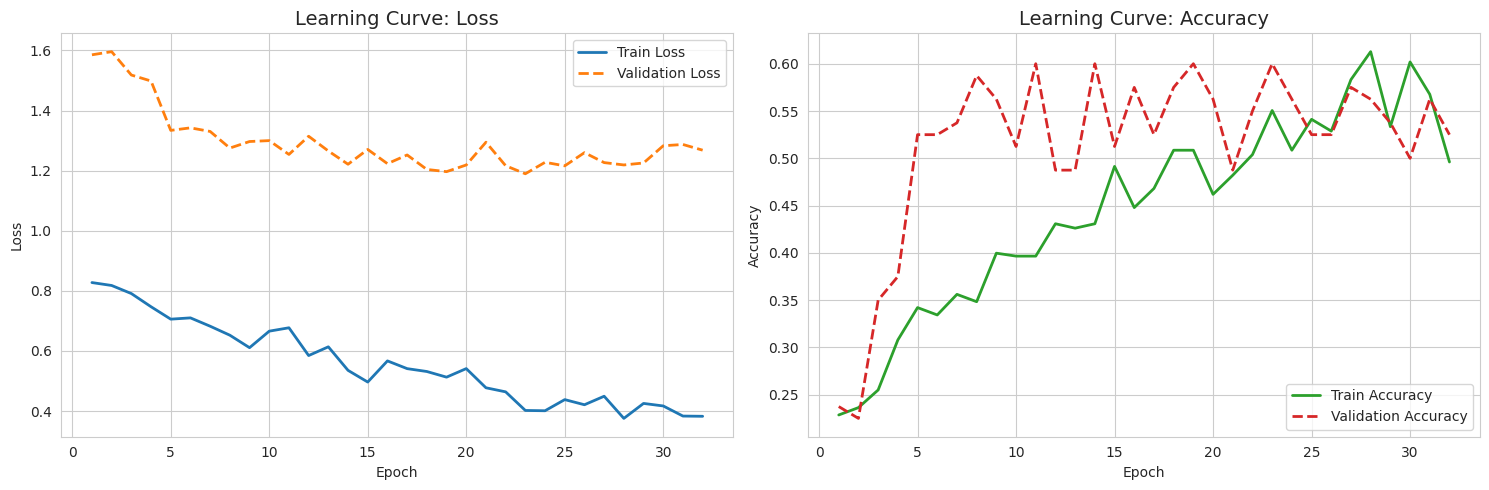

Final Train Accuracy: 0.4961
Final Val Accuracy:   0.5250
Best Val Accuracy:    0.6000


In [23]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Load History
if 'history' not in globals() or len(history.get("epoch", [])) == 0:
    try:
        with open("training_history.json") as f:
            history = json.load(f)
    except FileNotFoundError:
        print("File history tidak ditemukan. Pastikan training sudah selesai.")
        history = None

if history and len(history.get("epoch", [])) > 0:
    epochs = history["epoch"]
    
    # Setup Style
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss
    axes[0].plot(epochs, history["tr_loss"], label="Train Loss", color='tab:blue', linewidth=2)
    axes[0].plot(epochs, history["val_loss"], label="Validation Loss", color='tab:orange', linewidth=2, linestyle='--')
    axes[0].set_title("Learning Curve: Loss", fontsize=14)
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Plot Accuracy
    axes[1].plot(epochs, history["tr_acc"], label="Train Accuracy", color='tab:green', linewidth=2)
    axes[1].plot(epochs, history["val_acc"], label="Validation Accuracy", color='tab:red', linewidth=2, linestyle='--')
    axes[1].set_title("Learning Curve: Accuracy", fontsize=14)
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    
    # Tampilkan Summary Metrics Terakhir
    print(f"Final Train Accuracy: {history['tr_acc'][-1]:.4f}")
    print(f"Final Val Accuracy:   {history['val_acc'][-1]:.4f}")
    print(f"Best Val Accuracy:    {max(history['val_acc']):.4f}")

Running Evaluation on: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Checkpoint loaded: mer_trimodal_best.pt
Running Inference on Test Set...


Testing:   0%|          | 0/5 [00:00<?, ?it/s]


TEST SET METRICS
Akurasi   : 0.4321
F1-Score  : 0.4133
Precision : 0.4683
Recall    : 0.4321

Detailed Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.143     0.250         7
           1      0.250     0.176     0.207        17
           2      0.571     0.727     0.640        22
           3      0.321     0.474     0.383        19
           4      0.500     0.375     0.429        16

    accuracy                          0.432        81
   macro avg      0.529     0.379     0.382        81
weighted avg      0.468     0.432     0.413        81



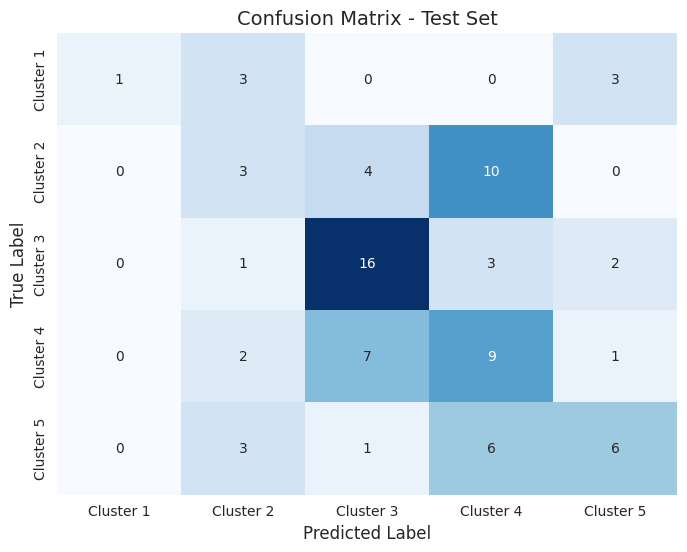


Total Success Cases: 35
Total Failure Cases: 46

--- CONTOH BERHASIL (Success Cases) (Random 3 samples) ---
✅ Song ID: 485
   True: Cluster 3 | Pred: Cluster 3
   Confidence: 0.4737
------------------------------
✅ Song ID: 583
   True: Cluster 4 | Pred: Cluster 4
   Confidence: 0.2949
------------------------------
✅ Song ID: 345
   True: Cluster 3 | Pred: Cluster 3
   Confidence: 0.5797
------------------------------

--- CONTOH GAGAL (Failure Cases) (Random 3 samples) ---
❌ Song ID: 373
   True: Cluster 3 | Pred: Cluster 5
   Confidence: 0.3007
------------------------------
❌ Song ID: 309
   True: Cluster 2 | Pred: Cluster 3
   Confidence: 0.4488
------------------------------
❌ Song ID: 855
   True: Cluster 5 | Pred: Cluster 3
   Confidence: 0.2765
------------------------------


In [24]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running Evaluation on: {device}")

# --- Load Model ---
model_test = TriModalMER(
    d=512,
    roberta_name="roberta-base",
    midi_in_chans=1,
    n_class=5,
    freeze_roberta_layers=2,
    midi_seq_spatial=True,
).to(device)

ckpt_path = "mer_trimodal_best.pt"

if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    # Handle jika save state_dict dibungkus dalam key 'model' atau tidak
    if isinstance(ckpt, dict) and "model" in ckpt:
        model_test.load_state_dict(ckpt["model"])
    else:
        model_test.load_state_dict(ckpt)
    print(f"Checkpoint loaded: {ckpt_path}")
else:
    print(f"WARNING: Checkpoint {ckpt_path} tidak ditemukan! Menggunakan random weights.")

model_test.eval()

if 'test_ids' not in globals():
    with open("splits.json") as f:
        splits = json.load(f)
        test_ids = splits['test']

test_ds = MIREXMultiModalDataset(
    split="test",
    roberta_name="roberta-base",
    max_lyric_tokens=384,
    ids=test_ids,
    use_class_label=True,
)

test_dl = DataLoader(
    test_ds,
    batch_size=18,
    shuffle=False,
    num_workers=0,
    pin_memory=(device == "cuda"),
    collate_fn=collate_fn,
)

all_preds = []
all_labels = []
all_ids = []
all_probs = []

print("Running Inference on Test Set...")
with torch.no_grad():
    for b in tqdm(test_dl, desc="Testing"):
        mel = b["mel"].to(device)
        ids_input = b["input_ids"].to(device)
        att = b["attention_mask"].to(device)
        midi = b["midi_img"].to(device)
        midi_feat = b["midi_feat"].to(device)
        mka = b["mask_a"]
        mkl = b["mask_l"].to(device)
        mkm = b["mask_m"]
        y = b["label"].to(device)
        ids_song = b["ids"] # Ambil ID lagu untuk tracking failure case

        _, cls_pred = model_test(mel, ids_input, att, midi, midi_feat, mka, mkl, mkm)
        
        probs = torch.softmax(cls_pred, dim=1)
        preds = cls_pred.argmax(-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_ids.extend(ids_song.numpy())
        all_probs.extend(probs.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')

print(f"\n{'='*40}")
print(f"TEST SET METRICS")
print(f"{'='*40}")
print(f"Akurasi   : {acc:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"{'='*40}\n")

print("Detailed Classification Report:")
print(classification_report(all_labels, all_preds, digits=3))

# --- 2. Visualisasi Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
class_names = [f"Cluster {i+1}" for i in range(5)] # MIREX biasanya Cluster 1-5

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14)
plt.show()

# --- 3. Analisis Success & Failure Cases ---
results_df = pd.DataFrame({
    'song_id': all_ids,
    'true_label': all_labels,
    'pred_label': all_preds,
    'confidence': [p[pred] for p, pred in zip(all_probs, all_preds)]
})

# Mapping label angka ke nama
label_map = {i: f"Cluster {i+1}" for i in range(5)}
results_df['true_str'] = results_df['true_label'].map(label_map)
results_df['pred_str'] = results_df['pred_label'].map(label_map)

success_cases = results_df[results_df['true_label'] == results_df['pred_label']]
failure_cases = results_df[results_df['true_label'] != results_df['pred_label']]

print(f"\nTotal Success Cases: {len(success_cases)}")
print(f"Total Failure Cases: {len(failure_cases)}")

def display_cases(df, title, n=3):
    if len(df) == 0:
        print(f"\n{title}: Tidak ada data.")
        return
    
    sample = df.sample(min(n, len(df)), random_state=42)
    print(f"\n--- {title} (Random {len(sample)} samples) ---")
    for _, row in sample.iterrows():
        status = "✅" if row['true_label'] == row['pred_label'] else "❌"
        print(f"{status} Song ID: {row['song_id']}")
        print(f"   True: {row['true_str']} | Pred: {row['pred_str']}")
        print(f"   Confidence: {row['confidence']:.4f}")
        print("-" * 30)

display_cases(success_cases, "CONTOH BERHASIL (Success Cases)", n=3)
display_cases(failure_cases, "CONTOH GAGAL (Failure Cases)", n=3)